# Scratch

In [171]:
# imports
import pandas as pd
import numpy as np
import os
import wrangle.py as w

from scipy import stats

from datetime import datetime
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

# modeling methods
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, RFE

ModuleNotFoundError: No module named 'wrangle'

# Project Goals
> - Find drivers for Profit using SuperStore data available in Texas.
> - Construct an ML Regression model that beats the baseline in predicting Profit.
> - Determine weak areas

# Executive Summary
> - Top Drivers were Category, Sub-Category, and Segment
> - The OLS Regression model beat our baseline in predicting Profit with an RMSE of 85.98 compared to the baseline RMSE of 259.47.
> - Overall Texas is losing money with Office Supplies consisting of 61% of sales. There is no difference between office supplies profit and Texas Mean Profit

# Acquire and Prep

In [2]:
df = pd.read_csv('SampleSuperstore.csv')

In [3]:
df.head()

,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.9600,2,0.00,41.9136
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.9400,3,0.00,219.5820
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.6200,2,0.00,6.8714
3,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.5775,5,0.45,-383.0310
4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.3680,2,0.20,2.5164


In [10]:
for col in df.columns:
    print(f"Column: {col}")
    print("List of Values: ")
    print(df[col].unique())
    print("---------------------")

Column: Ship Mode
List of Values: 
['Second Class' 'Standard Class' 'First Class' 'Same Day']
---------------------
Column: Segment
List of Values: 
['Consumer' 'Corporate' 'Home Office']
---------------------
Column: Country
List of Values: 
['United States']
---------------------
Column: City
List of Values: 
['Henderson' 'Los Angeles' 'Fort Lauderdale' 'Concord' 'Seattle'
 'Fort Worth' 'Madison' 'West Jordan' 'San Francisco' 'Fremont'
 'Philadelphia' 'Orem' 'Houston' 'Richardson' 'Naperville' 'Melbourne'
 'Eagan' 'Westland' 'Dover' 'New Albany' 'New York City' 'Troy' 'Chicago'
 'Gilbert' 'Springfield' 'Jackson' 'Memphis' 'Decatur' 'Durham' 'Columbia'
 'Rochester' 'Minneapolis' 'Portland' 'Saint Paul' 'Aurora' 'Charlotte'
 'Orland Park' 'Urbandale' 'Columbus' 'Bristol' 'Wilmington' 'Bloomington'
 'Phoenix' 'Roseville' 'Independence' 'Pasadena' 'Newark' 'Franklin'
 'Scottsdale' 'San Jose' 'Edmond' 'Carlsbad' 'San Antonio' 'Monroe'
 'Fairfield' 'Grand Prairie' 'Redlands' 'Hamilton' 'We

In [19]:
df.City[df.City.str.startswith("S")].unique()
# Found San Antonio

array(['Seattle', 'San Francisco', 'Springfield', 'Saint Paul',
       'Scottsdale', 'San Jose', 'San Antonio', 'Saginaw', 'Santa Clara',
       'San Diego', 'Saint Petersburg', 'Salem', 'Sierra Vista',
       'Santa Ana', 'Salinas', 'Saint Peters', 'Smyrna', 'Skokie',
       'Suffolk', 'South Bend', 'Spokane', 'San Bernardino', 'Stockton',
       'Sunnyvale', 'Saint Louis', 'San Angelo', 'Salt Lake City',
       'Southaven', 'Sioux Falls', 'Sacramento', 'Sparks', 'Summerville',
       'Sterling Heights', 'San Mateo', 'Santa Fe', 'Saint Cloud',
       'Superior', 'San Gabriel', 'Sandy Springs', 'Santa Barbara',
       'Santa Maria', 'Saint Charles', 'Sheboygan', 'Shelton', 'Sanford',
       'San Marcos', 'San Clemente', 'San Luis Obispo', 'Springdale'],
      dtype=object)

In [21]:
len(df[df.City == "San Antonio"])

59

In [23]:
df.isna().sum()
# No missing values

Ship Mode       0
Segment         0
Country         0
City            0
State           0
Postal Code     0
Region          0
Category        0
Sub-Category    0
Sales           0
Quantity        0
Discount        0
Profit          0
dtype: int64

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ship Mode     9994 non-null   object 
 1   Segment       9994 non-null   object 
 2   Country       9994 non-null   object 
 3   City          9994 non-null   object 
 4   State         9994 non-null   object 
 5   Postal Code   9994 non-null   int64  
 6   Region        9994 non-null   object 
 7   Category      9994 non-null   object 
 8   Sub-Category  9994 non-null   object 
 9   Sales         9994 non-null   float64
 10  Quantity      9994 non-null   int64  
 11  Discount      9994 non-null   float64
 12  Profit        9994 non-null   float64
dtypes: float64(3), int64(2), object(8)
memory usage: 1015.1+ KB


In [27]:
df = df[df.State=='Texas']
#only focus on Texas

In [35]:
cats = ['Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']
cont = ['Postal Code', 'Sales', 'Quantity', 'Discount', 'Profit']

In [173]:
df.describe()

,Postal Code,Sales,Quantity,Discount,Profit,Category_Office Supplies,Category_Technology,Sub-Category_Accessories,Sub-Category_Appliances,Sub-Category_Art,...,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies,Sub-Category_Tables,Segment_Consumer,Segment_Corporate,Segment_Home Office
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,...,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.00000,985.000000,985.000000
mean,76901.211168,172.779742,3.780711,0.370193,-26.121174,0.613198,0.181726,0.082234,0.047716,0.072081,...,0.030457,0.013198,0.149239,0.081218,0.084264,0.019289,0.033503,0.53198,0.316751,0.151269
std,1251.940629,424.447771,2.158043,0.243362,189.022781,0.487265,0.385814,0.274860,0.213272,0.258754,...,0.171928,0.114180,0.356504,0.273309,0.277924,0.137610,0.180036,0.49923,0.465446,0.358493
min,75002.000000,0.444000,1.000000,0.200000,-3701.892800,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,76017.000000,10.824000,2.000000,0.200000,-17.027400,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,77041.000000,36.288000,3.000000,0.200000,0.333600,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000
75%,77506.000000,158.376000,5.000000,0.600000,6.998600,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000
max,79907.000000,8159.952000,14.000000,0.800000,624.987500,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


# Distribution Visualizations

## Distributions of Profit by City

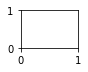

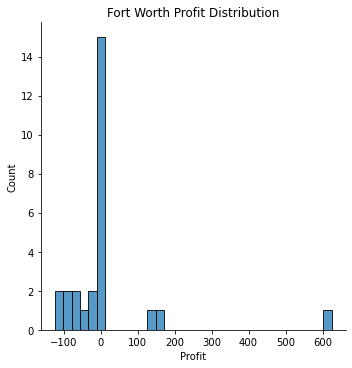

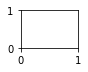

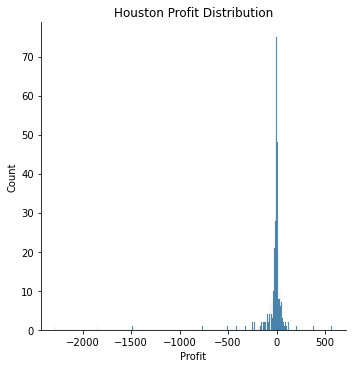

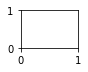

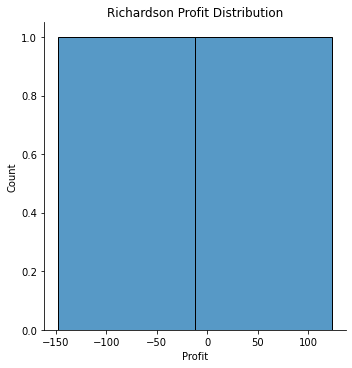

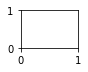

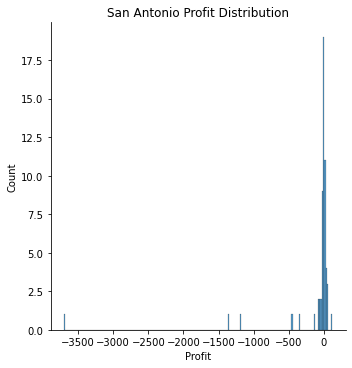

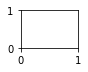

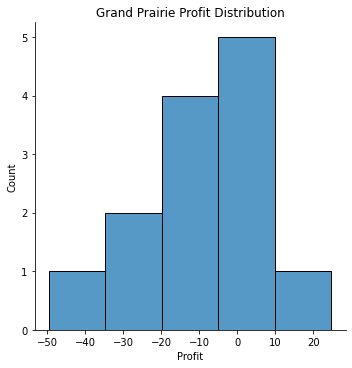

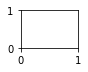

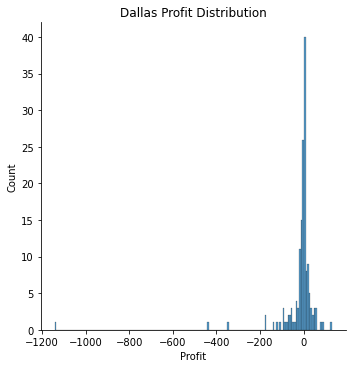

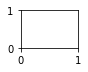

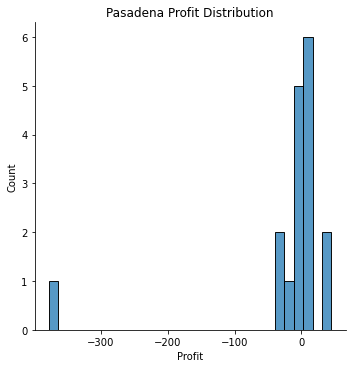

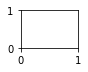

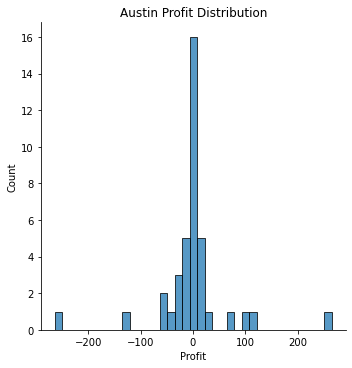

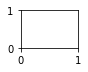

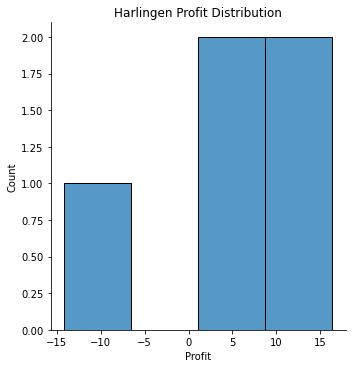

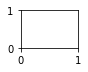

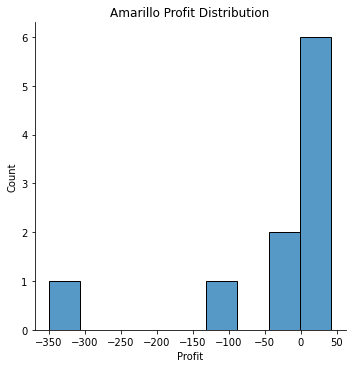

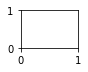

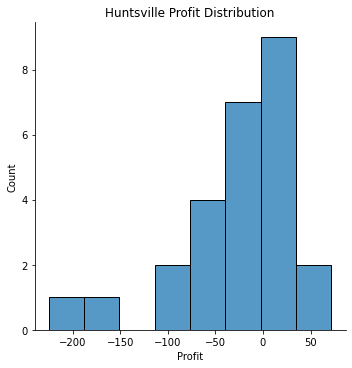

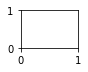

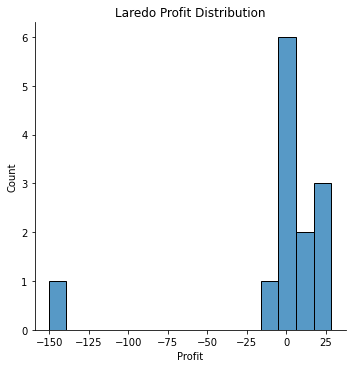

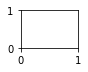

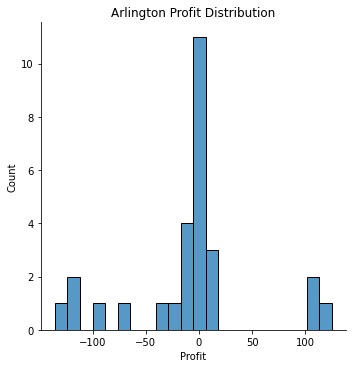

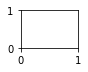

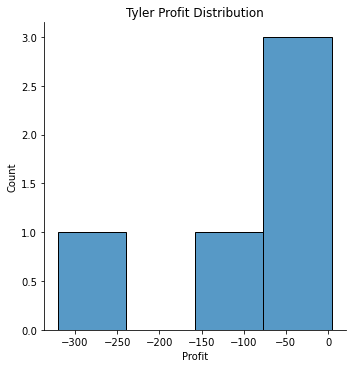

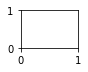

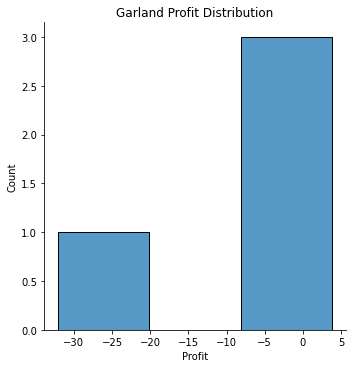

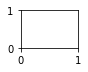

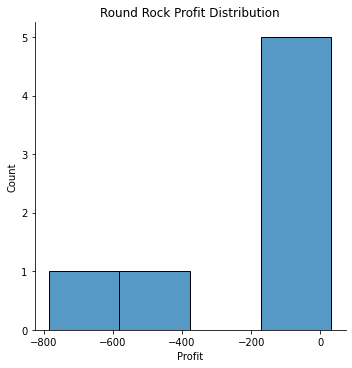

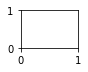

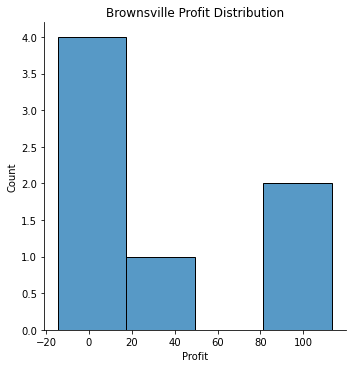

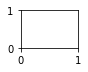

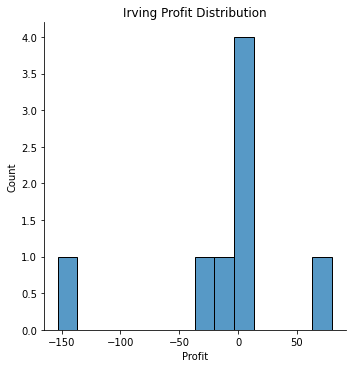

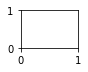

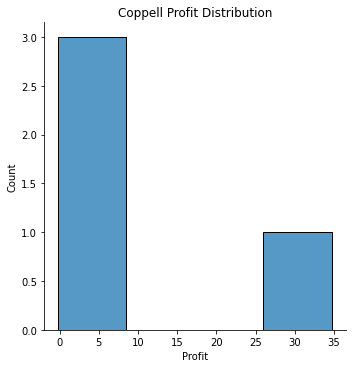

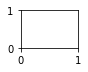

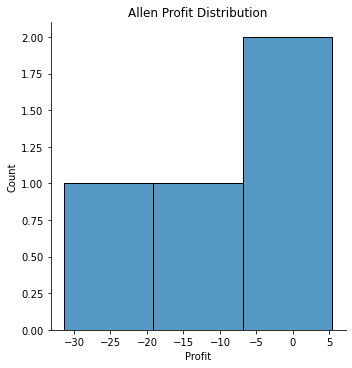

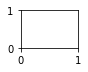

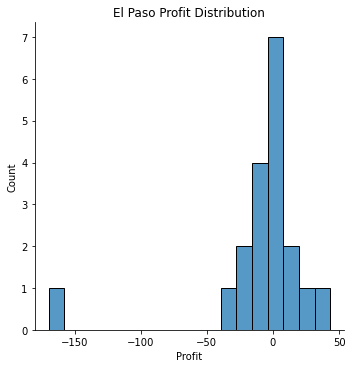

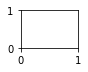

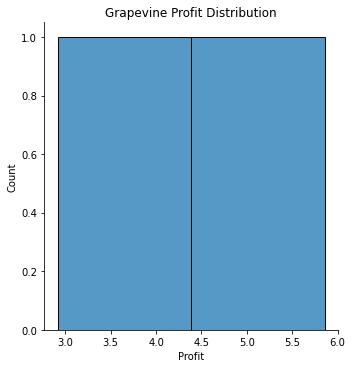

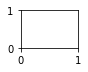

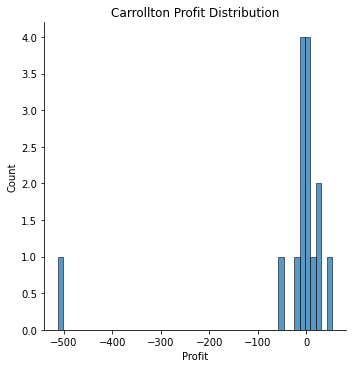

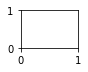

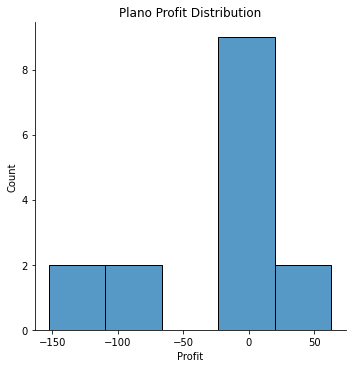

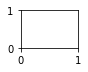

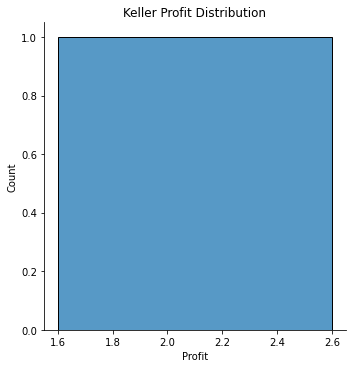

ValueError: num must be 1 <= num <= 25, not 26

<Figure size 432x288 with 0 Axes>

In [174]:
for c in df.City.unique():
    sns.displot(x='Profit', data=df[(df.City == c)])
    plt.title(f'{c} Profit Distribution')
    plt.show()

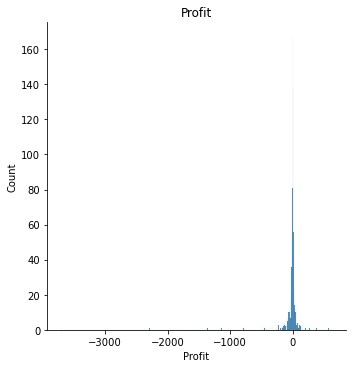

In [33]:
sns.displot(x='Profit', data=df)
plt.title('Profit')
plt.show()

# Takeaways:
- There are some outliers in the negative direction for Profit. 

In [45]:
Profit_by_City = df.groupby('City').Profit.sum() # groups data by City and gives a sum of all profits. 

<AxesSubplot:xlabel='City'>

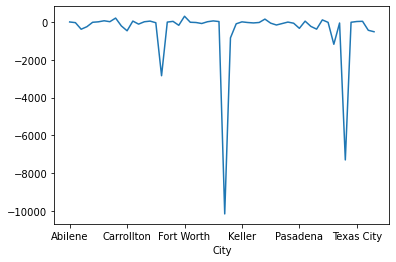

In [47]:
Profit_by_City.plot()

# Takeaways:
- Most cities are are hovering at $0 profit
- Some cities are experiencing heavy loses in profit

<AxesSubplot:>

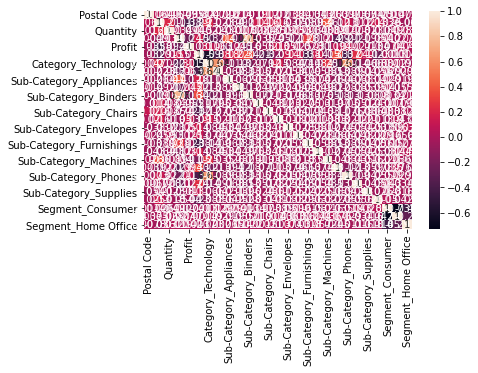

In [170]:
sns.heatmap(df.corr(), annot = True)

# Takeaways
- Quantity and Sales seem to have correlation. 
-  Little to no correlation in other areas for continous variables. 

## Visualization of Count per Column

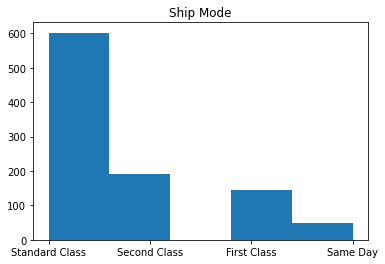

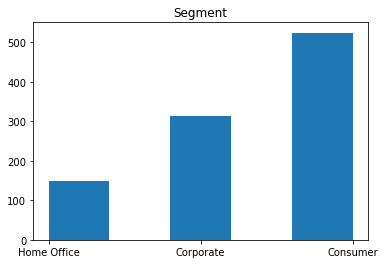

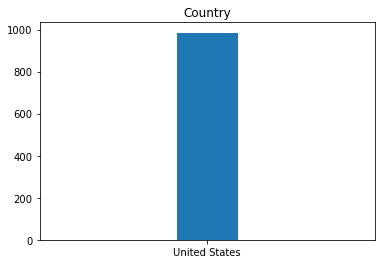

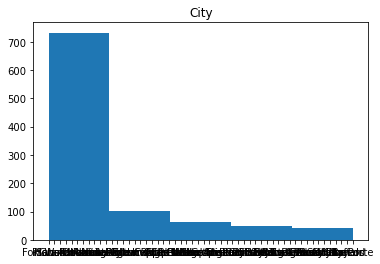

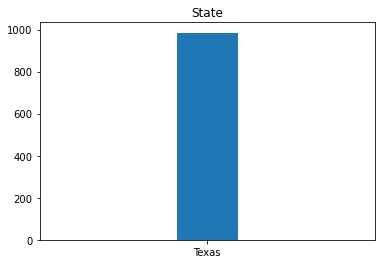

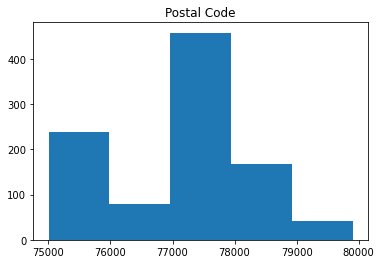

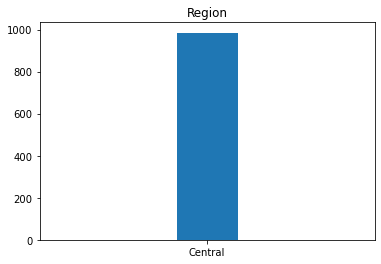

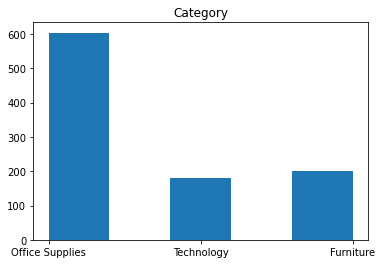

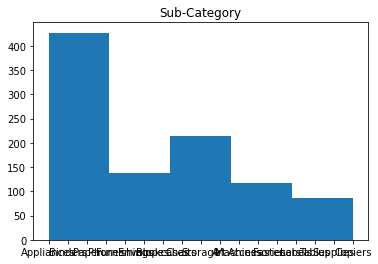

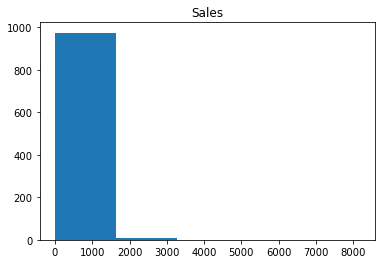

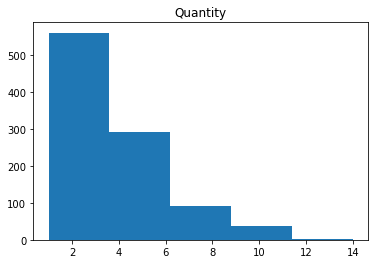

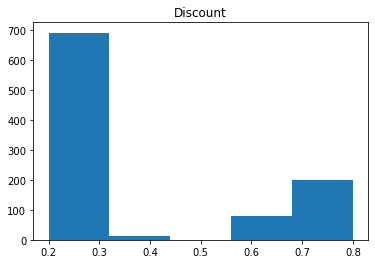

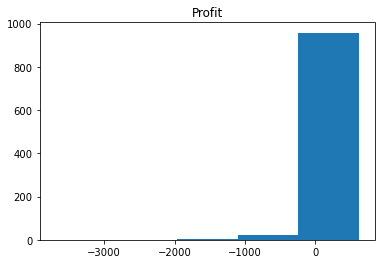

In [40]:
for i, col in enumerate(df.columns):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    #plt.subplot(1,12, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    plt.show()

# Takeaways:
- Standard class is most common
- Consumer segment is most common
- Region, Country, and State are the same for all, so we can drop those columns. 
- "Office Supplies" seem to be the most sold category. 

In [53]:
Profit_by_City[Profit_by_City > 0]
# list of cities making a profit

City
Baytown          3.6288
Beaumont        59.1164
Bedford         10.6202
Brownsville    202.0720
Cedar Hill      42.8316
Conroe           6.9795
Coppell         41.4892
Edinburg        27.8086
Fort Worth     298.7327
Grapevine        8.7749
Haltom City     51.9558
Harlingen       18.1275
Keller           2.1000
Lubbock        147.1387
Pearland        39.4131
Port Arthur    105.7760
Texas City      20.2218
The Colony      31.6586
Name: Profit, dtype: float64

In [60]:
profitable_cities = list(Profit_by_City[Profit_by_City > 0].index)
profitable_cities

['Baytown',
 'Beaumont',
 'Bedford',
 'Brownsville',
 'Cedar Hill',
 'Conroe',
 'Coppell',
 'Edinburg',
 'Fort Worth',
 'Grapevine',
 'Haltom City',
 'Harlingen',
 'Keller',
 'Lubbock',
 'Pearland',
 'Port Arthur',
 'Texas City',
 'The Colony']

In [56]:
df.Profit.sum()
# Overall Texas is losing Profit

-25729.3563

In [63]:
for c in profitable_cities:
    print(f'Top 5 Products Sold in {c}')
    print(df[df.City == c]['Sub-Category'].value_counts().head())
    print("------------------")
    

Top 5 Products Sold in Baytown
Paper    1
Name: Sub-Category, dtype: int64
------------------
Top 5 Products Sold in Beaumont
Accessories    2
Binders        1
Furnishings    1
Storage        1
Name: Sub-Category, dtype: int64
------------------
Top 5 Products Sold in Bedford
Paper      2
Binders    1
Phones     1
Art        1
Name: Sub-Category, dtype: int64
------------------
Top 5 Products Sold in Brownsville
Chairs       1
Phones       1
Storage      1
Supplies     1
Bookcases    1
Name: Sub-Category, dtype: int64
------------------
Top 5 Products Sold in Cedar Hill
Envelopes    1
Paper        1
Name: Sub-Category, dtype: int64
------------------
Top 5 Products Sold in Conroe
Storage    1
Name: Sub-Category, dtype: int64
------------------
Top 5 Products Sold in Coppell
Art        2
Storage    1
Phones     1
Name: Sub-Category, dtype: int64
------------------
Top 5 Products Sold in Edinburg
Binders      1
Paper        1
Fasteners    1
Name: Sub-Category, dtype: int64
--------------

In [65]:
df['Sub-Category'].value_counts().head()

Binders        153
Paper          147
Storage         83
Accessories     81
Furnishings     81
Name: Sub-Category, dtype: int64

### Top 5 sold products in Texas:
 - Binders
 - Paper
 - Storage
 - Accessories
 - Furnishings

In [66]:
df['Category'].value_counts()

Office Supplies    604
Furniture          202
Technology         179
Name: Category, dtype: int64

In [68]:
604 /(604+202+179)

0.6131979695431472

In [69]:
unprofitable_cities = list(Profit_by_City[Profit_by_City <= 0].index)
unprofitable_cities

['Abilene',
 'Allen',
 'Amarillo',
 'Arlington',
 'Austin',
 'Bryan',
 'Carrollton',
 'College Station',
 'Corpus Christi',
 'Dallas',
 'Deer Park',
 'El Paso',
 'Frisco',
 'Garland',
 'Grand Prairie',
 'Houston',
 'Huntsville',
 'Irving',
 'La Porte',
 'Laredo',
 'League City',
 'Mansfield',
 'Mcallen',
 'Mesquite',
 'Missouri City',
 'Odessa',
 'Pasadena',
 'Pharr',
 'Plano',
 'Richardson',
 'Round Rock',
 'San Angelo',
 'San Antonio',
 'San Marcos',
 'Tyler',
 'Waco']

In [70]:
for c in unprofitable_cities:
    print(f'Top 5 Products Sold in {c}')
    print(df[df.City == c]['Sub-Category'].value_counts().head())
    print("------------------")

Top 5 Products Sold in Abilene
Appliances    1
Name: Sub-Category, dtype: int64
------------------
Top 5 Products Sold in Allen
Binders        1
Tables         1
Accessories    1
Paper          1
Name: Sub-Category, dtype: int64
------------------
Top 5 Products Sold in Amarillo
Paper          3
Chairs         2
Accessories    2
Furnishings    1
Phones         1
Name: Sub-Category, dtype: int64
------------------
Top 5 Products Sold in Arlington
Binders        5
Storage        4
Furnishings    3
Paper          3
Tables         2
Name: Sub-Category, dtype: int64
------------------
Top 5 Products Sold in Austin
Binders        7
Storage        7
Paper          7
Accessories    5
Phones         3
Name: Sub-Category, dtype: int64
------------------
Top 5 Products Sold in Bryan
Binders    4
Storage    1
Chairs     1
Name: Sub-Category, dtype: int64
------------------
Top 5 Products Sold in Carrollton
Accessories    4
Binders        3
Furnishings    2
Paper          2
Supplies       1
Name: S

In [76]:
df[df.City == 'Waco']

,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
5174,Standard Class,Consumer,United States,Waco,Texas,76706,Central,Office Supplies,Binders,2.0720,2,0.80,-3.5224
5175,Standard Class,Consumer,United States,Waco,Texas,76706,Central,Furniture,Bookcases,328.3992,3,0.32,-91.7586
5773,Standard Class,Consumer,United States,Waco,Texas,76706,Central,Office Supplies,Storage,23.9680,2,0.20,2.3968
6566,Second Class,Consumer,United States,Waco,Texas,76706,Central,Office Supplies,Binders,243.9920,4,0.80,-426.9860
6567,Second Class,Consumer,United States,Waco,Texas,76706,Central,Office Supplies,Art,7.1200,5,0.20,0.7120
9292,Same Day,Corporate,United States,Waco,Texas,76706,Central,Office Supplies,Binders,0.5560,1,0.80,-0.9452


In [77]:
df[df.City == 'Waco'].Profit.sum()

-520.1034

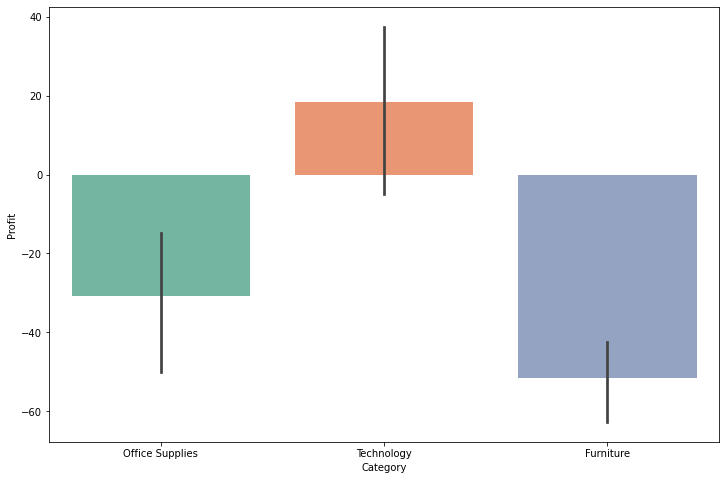

In [78]:
plt.figure(figsize=[12,8])
ax = sns.barplot(x="Category", y="Profit", data=df, palette="Set2")

# Takeaways:
- Technology appears to be the only one producing profit.
- Both "Office Supplies" and "Furniture" have negative profit. 

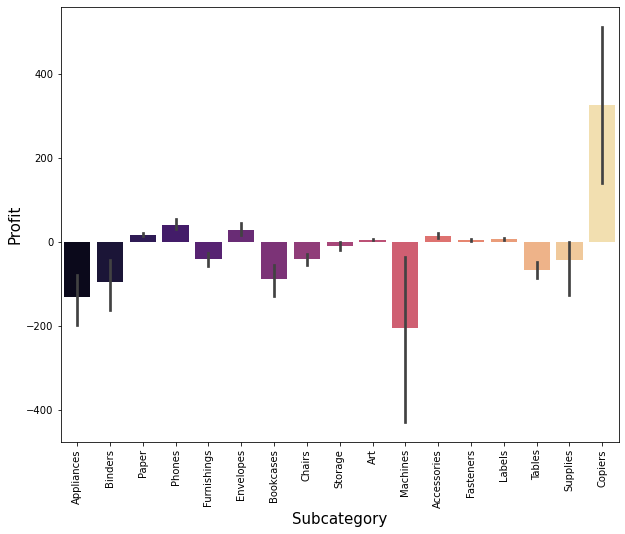

In [79]:
plt.figure(figsize=[10,8])
ax = sns.barplot(x="Sub-Category", y="Profit", data=df, palette="magma")
plt.xlabel("Subcategory", fontsize=15)
plt.ylabel("Profit",fontsize=15)
plt.xticks(rotation=90)
plt.show()


# Takeaways:
- Subcategories that lose money: Appliances, Binders, Furnishings, Bookcases, Chairs, Storage, Machines, Tables, Supplies
- Subcategories that make moeny: Paper, Phones, Envelopes, Art, Accessories, Fasteners, Labels, Copiers.
- Copiers made the most profit, and Machines took the most profit. 
- Top 4: Copiers, phones, envelopes, accesories

In [81]:
df_tech=df[(df['Category']=="Technology")]

Text(0, 0.5, 'Sales')

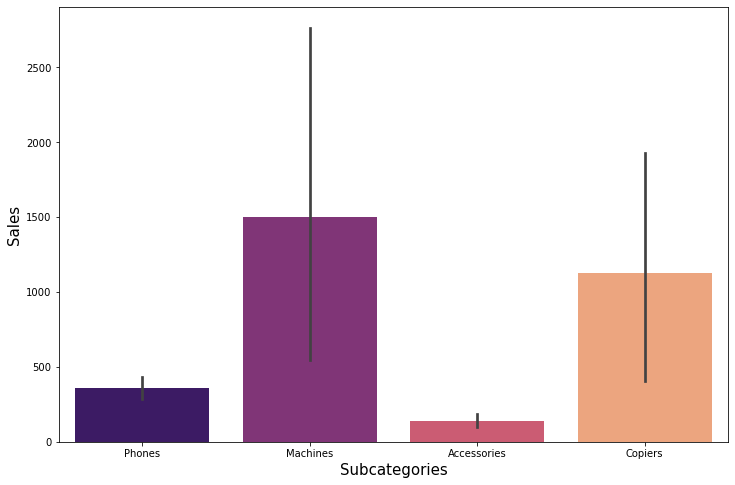

In [82]:
plt.figure(figsize=[12,8])
ax = sns.barplot(x="Sub-Category", y="Sales", data=df_tech, palette="magma")
plt.xlabel("Subcategories",fontsize=15)
plt.ylabel("Sales",fontsize=15)

# Takeaways:
- In Texas, we sold more machines than copiers. 

In [84]:
df.columns

Index(['Ship Mode', 'Segment', 'Country', 'City', 'State', 'Postal Code',
       'Region', 'Category', 'Sub-Category', 'Sales', 'Quantity', 'Discount',
       'Profit'],
      dtype='object')

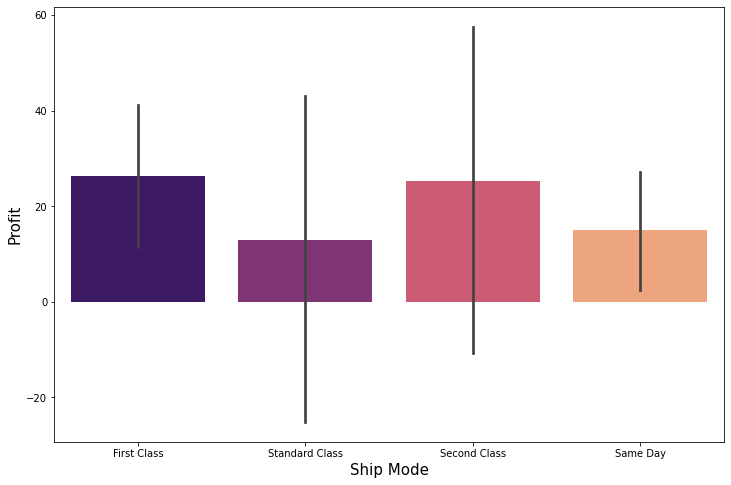

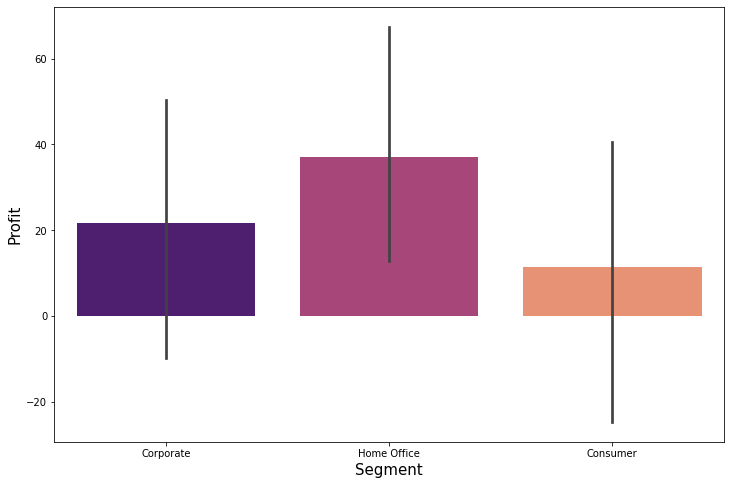

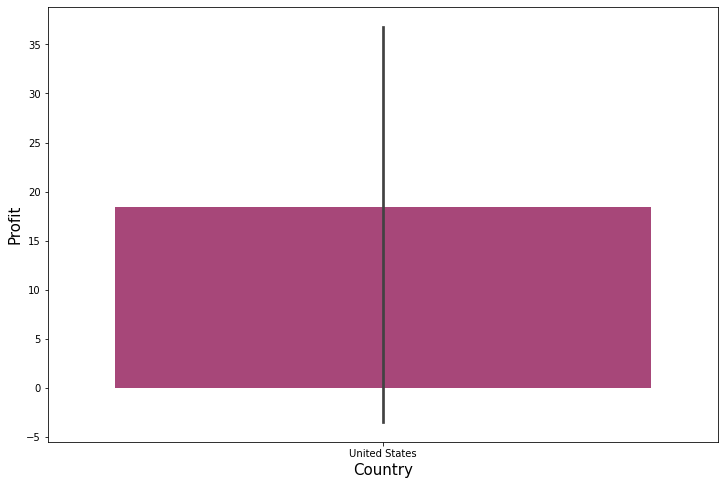

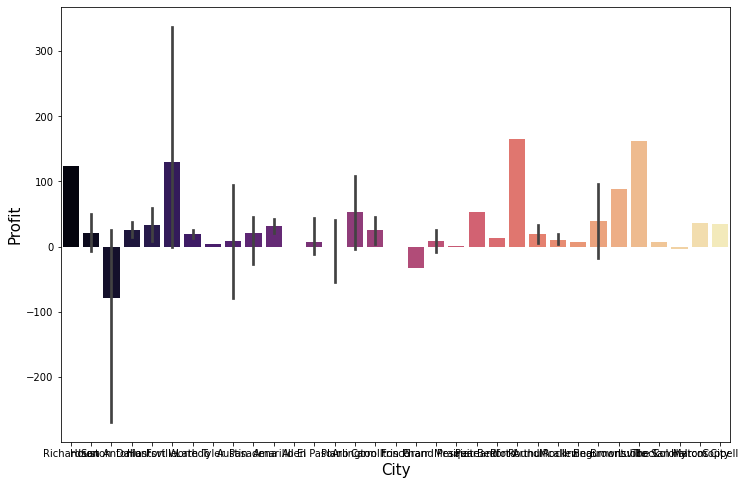

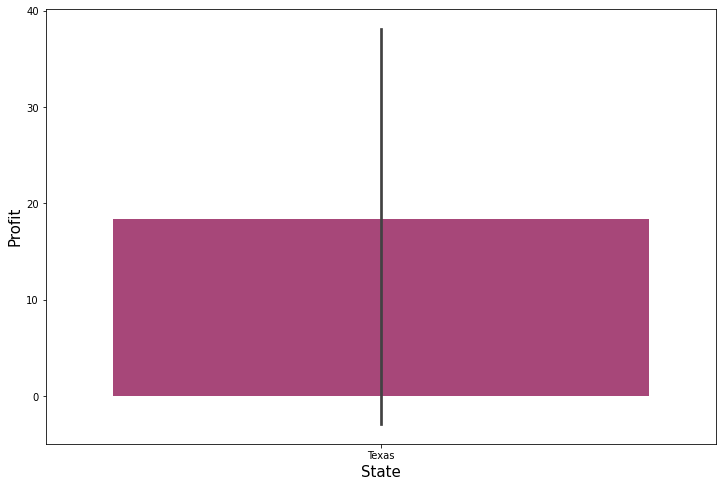

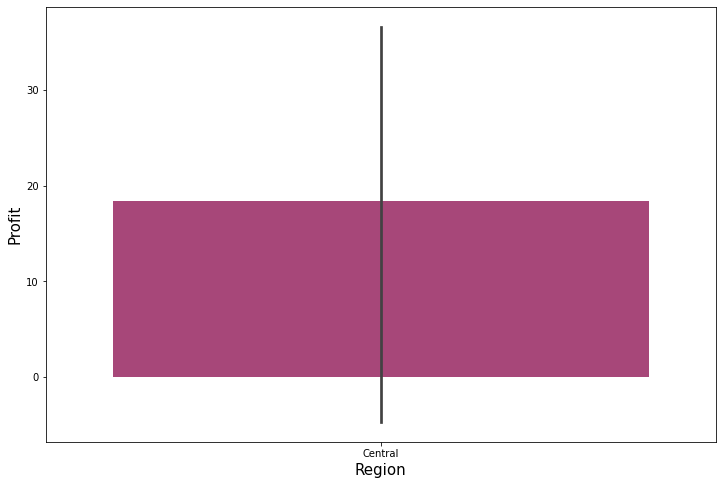

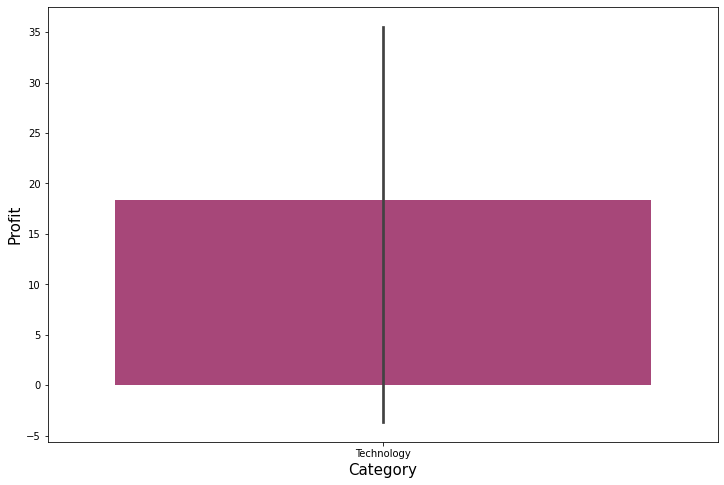

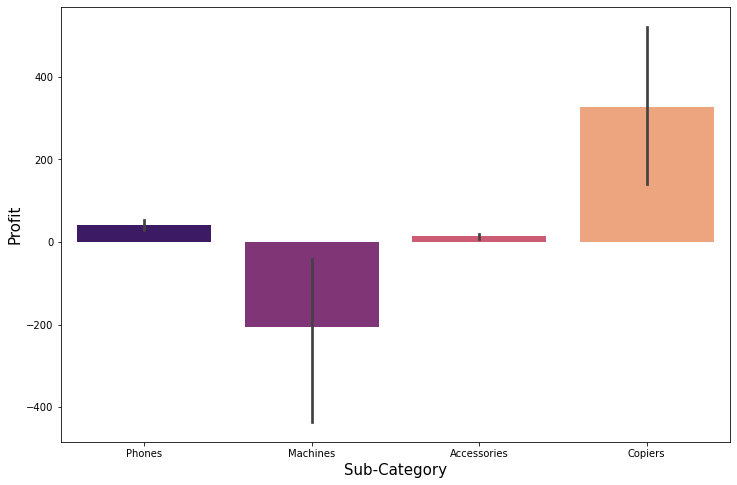

In [88]:
for c in cats:
    plt.figure(figsize=[12,8])
    ax = sns.barplot(x=c, y="Profit", data=df_tech, palette="magma")
    plt.xlabel(f"{c}",fontsize=15)
    plt.ylabel("Profit",fontsize=15)

In [139]:
dummy_df = pd.get_dummies(df[['Category',"Sub-Category","Segment"]])
dummy_df = dummy_df.drop(columns= ['Category_Furniture'])
df = pd.concat([df, dummy_df], axis=1)

In [140]:
df

,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,...,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies,Sub-Category_Tables,Segment_Consumer,Segment_Corporate,Segment_Home Office
14,Standard Class,Home Office,United States,Fort Worth,Texas,76106,Central,Office Supplies,Appliances,68.8100,...,0,0,0,0,0,0,0,0,0,1
15,Standard Class,Home Office,United States,Fort Worth,Texas,76106,Central,Office Supplies,Binders,2.5440,...,0,0,0,0,0,0,0,0,0,1
34,Second Class,Home Office,United States,Houston,Texas,77095,Central,Office Supplies,Paper,29.4720,...,0,0,1,0,0,0,0,0,0,1
35,First Class,Corporate,United States,Richardson,Texas,75080,Central,Technology,Phones,1097.5440,...,0,0,0,1,0,0,0,0,1,0
36,First Class,Corporate,United States,Richardson,Texas,75080,Central,Furniture,Furnishings,190.9200,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9919,Standard Class,Corporate,United States,Bryan,Texas,77803,Central,Furniture,Chairs,528.4300,...,0,0,0,0,0,0,0,0,1,0
9920,Standard Class,Corporate,United States,Bryan,Texas,77803,Central,Office Supplies,Binders,22.3860,...,0,0,0,0,0,0,0,0,1,0
9961,First Class,Home Office,United States,Houston,Texas,77041,Central,Office Supplies,Paper,65.5840,...,0,0,1,0,0,0,0,0,0,1
9962,First Class,Home Office,United States,Houston,Texas,77041,Central,Furniture,Bookcases,383.4656,...,0,0,0,0,0,0,0,0,0,1


In [143]:
df.columns

Index(['Ship Mode', 'Segment', 'Country', 'City', 'State', 'Postal Code',
       'Region', 'Category', 'Sub-Category', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Category_Office Supplies', 'Category_Technology',
       'Sub-Category_Accessories', 'Sub-Category_Appliances',
       'Sub-Category_Art', 'Sub-Category_Binders', 'Sub-Category_Bookcases',
       'Sub-Category_Chairs', 'Sub-Category_Copiers', 'Sub-Category_Envelopes',
       'Sub-Category_Fasteners', 'Sub-Category_Furnishings',
       'Sub-Category_Labels', 'Sub-Category_Machines', 'Sub-Category_Paper',
       'Sub-Category_Phones', 'Sub-Category_Storage', 'Sub-Category_Supplies',
       'Sub-Category_Tables', 'Segment_Consumer', 'Segment_Corporate',
       'Segment_Home Office'],
      dtype='object')

# Split

In [141]:
def split(df):
    '''
    take in a DataFrame and return train, validate, and test DataFrames.
    return train, validate, test DataFrames.
    '''
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, 
                                       test_size=.3, 
                                       random_state=123)
    return train, validate, test

In [142]:
train, validate, test = split(df)
train.shape, validate.shape, test.shape

((551, 35), (237, 35), (197, 35))

In [144]:
def make_vars():
    
    target = "Profit"
    clist = ['Category_Office Supplies', 'Category_Technology',
       'Sub-Category_Accessories', 'Sub-Category_Appliances',
       'Sub-Category_Art', 'Sub-Category_Binders', 'Sub-Category_Bookcases',
       'Sub-Category_Chairs', 'Sub-Category_Copiers', 'Sub-Category_Envelopes',
       'Sub-Category_Fasteners', 'Sub-Category_Furnishings',
       'Sub-Category_Labels', 'Sub-Category_Machines', 'Sub-Category_Paper',
       'Sub-Category_Phones', 'Sub-Category_Storage', 'Sub-Category_Supplies',
       'Sub-Category_Tables', 'Segment_Consumer', 'Segment_Corporate',
       'Segment_Home Office']

    # split train into X (dataframe, only col in list) & y (series, keep target only)
    X_train = train[clist]
    y_train = train[target]
    y_train = pd.DataFrame(y_train)
    
    # split validate into X (dataframe, only col in list) & y (series, keep target only)
    X_validate = validate[clist]
    y_validate = validate[target]
    y_validate = pd.DataFrame(y_validate)

    # split test into X (dataframe, only col in list) & y (series, keep target only)
    X_test = test[clist]
    y_test = test[target]
    y_test = pd.DataFrame(y_test)
    
    return target, X_train, y_train, X_validate, y_validate, X_test, y_test

In [145]:
target, X_train, y_train, X_validate, y_validate, X_test, y_test = make_vars()
target, X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape

('Profit', (551, 22), (551, 1), (237, 22), (237, 1), (197, 22), (197, 1))

# T-Test

> - **Hypothesis 1 -** Tech Cat Profit vs Texas Mean Profit
> - alpha = .05
> - $H_0$: There is no difference between Tehnology Category Profit and Texas Mean Profit.  
> - $H_a$: There is a difference between Technology Category Profit and Texas Mean Profit. 
> - Outcome: I rejected the Null Hypothesis; Therefore we reject that there is no difference between Technology Category Profit and Texas Mean Profit.

In [111]:

a = 0.05


<AxesSubplot:xlabel='Profit', ylabel='Density'>

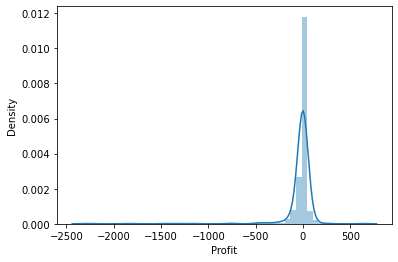

In [101]:
sns.distplot(train.Profit)

In [149]:
train.Profit.mean(), train.Profit.median()
# relatively close considering the outlier is over 2000 units away in profit

(-28.804090018148788, -0.6265)

<AxesSubplot:xlabel='Category', ylabel='Profit'>

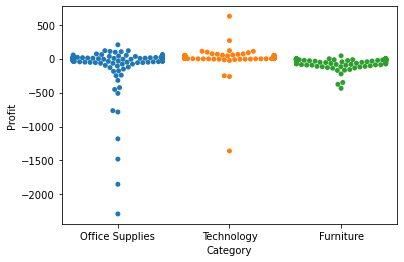

In [96]:
sns.swarmplot(x='Category', y='Profit', data=train)

In [128]:
tech_profit = train[train.Category == 'Technology'].Profit
Texas_mean_profit = train.Profit.mean()

t, p = stats.ttest_1samp(tech_profit, Texas_mean_profit)
t, p

(2.512045629851487, 0.013654022542876613)

A smaller p-value means that there is stronger evidence in favor of the alternative hypothesis.

In [116]:
if p < a:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypthesis")

We reject the null hypothesis


> - **Hypothesis 2 -** Office Cat Profit vs Texas Mean Profit
> - alpha = .05
> - $H_0$: There is no difference between "Office Supplies" Category Profit and Texas Mean Profit.  
> - $H_a$: There is a difference between "Office Supplies" Category Profit and Texas Mean Profit. 
> - Outcome: I fail to reject the Null Hypothesis; Therefore we fail to reject that there is no difference between "Office Supplies" Category Profit and Texas Mean Profit.

In [129]:
office_profit = train[train.Category == 'Office Supplies'].Profit
Texas_mean_profit = train.Profit.mean()

t, p = stats.ttest_1samp(office_profit, Texas_mean_profit)
t, p

(-0.44757128136166013, 0.6547562841990421)

In [130]:
if p < a:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypthesis")

We fail to reject the null hypthesis


# Takeaways:
- Office Supplies may be the reason we see profits fall in Texas
- Tech may be the reason we see profits rise in Texas

# Modeling

### Baseline

In [150]:
# 1. Predict taxvalue_pred_mean
profit_pred_mean = y_train.Profit.mean()
y_train['profit_pred_mean'] = profit_pred_mean
y_validate['profit_pred_mean'] = profit_pred_mean


# 2. compute taxvalue_pred_median
profit_pred_median = y_train.Profit.median()
y_train['profit_pred_median'] = profit_pred_median
y_validate['profit_pred_median'] = profit_pred_median


# 3. RMSE of taxvalue_pred_mean
rmse_train = mean_squared_error(y_train.Profit, y_train.profit_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.Profit, y_validate.profit_pred_mean) ** (1/2)
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of taxvalue_pred_median
rmse_train = mean_squared_error(y_train.Profit, y_train.profit_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.Profit, y_validate.profit_pred_median) ** .5
print("\nRMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  179.17 
Validate/Out-of-Sample:  259.47

RMSE using Median
Train/In-Sample:  181.37 
Validate/Out-of-Sample:  260.7


My train sample mean has a lower RMSE value, so I will use that as my baseline. 

In [132]:
def make_metric_df(y, y_pred, model_name, metric_df):
    if metric_df.size ==0:
        metric_df = pd.DataFrame(data=[
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }])
        return metric_df
    else:
        return metric_df.append(
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }, ignore_index=True)

In [133]:
metric_df = pd.DataFrame()
metric_df = make_metric_df(y_validate.Profit,
                           y_validate.profit_pred_mean,
                           'mean_baseline',
                          metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,259.470784,0.0


### OLS

In [151]:
def linear_regression():

    lm = LinearRegression(normalize=True)

    lm.fit(X_train, y_train.Profit)

    y_train['profit_pred_lm'] = lm.predict(X_train)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.Profit, y_train.profit_pred_lm) ** (1/2)

    # predict validate
    y_validate['profit_pred_lm'] = lm.predict(X_validate)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.Profit, y_validate.profit_pred_lm) ** (1/2)

    return print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
                  "\nValidation/Out-of-Sample: ", rmse_validate)

In [152]:
linear_regression()

RMSE for OLS using LinearRegression
Training/In-Sample:  166.42579483293395 
Validation/Out-of-Sample:  253.68869739725804


In [153]:
metric_df = make_metric_df(y_validate.Profit,
                           y_validate.profit_pred_lm,
                           'OLS Regressor',
                          metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,259.470784,0.000000
1,OLS Regressor,253.688697,0.043996


## Lasso+Lars with alpha = 1

In [155]:
def lassolars(a):
    # given a for alpha
    
    # create the model object
    lars = LassoLars(alpha=a)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series!
    lars.fit(X_train, y_train.Profit)

    # predict train
    y_train['profit_pred_lars'] = lars.predict(X_train)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.Profit, y_train.profit_pred_lars) ** (1/2)

    # predict validate
    y_validate['profit_pred_lars'] = lars.predict(X_validate)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.Profit, y_validate.profit_pred_lars) ** (1/2)

    return print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [156]:
lassolars(1)

RMSE for Lasso + Lars
Training/In-Sample:  176.3350496504282 
Validation/Out-of-Sample:  258.0444717829226


In [157]:
metric_df = make_metric_df(y_validate.Profit,
               y_validate.profit_pred_lars,
               'lasso_alpha_1',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,259.470784,0.000000
1,OLS Regressor,253.688697,0.043996
2,lasso_alpha_1,258.044472,0.011049


# Polynomial to the 2nd Degree

In [158]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)

In [159]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.Profit)

# predict train
y_train['profit_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Profit, y_train.profit_pred_lm2)**(1/2)

# predict validate
y_validate['profit_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Profit, y_validate.profit_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  159.35733228649673 
Validation/Out-of-Sample:  311.9462279108254


In [160]:
metric_df = make_metric_df(y_validate.Profit,
               y_validate.profit_pred_lm2,
               'Polynomiald2',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,259.470784,0.000000
1,OLS Regressor,253.688697,0.043996
2,lasso_alpha_1,258.044472,0.011049
3,Polynomiald2,311.946228,-0.429973


OLS was my best model with an RMSE of 253 (6 below baseline) and .043 r2.

# Run OLS on TEST

In [161]:
def linear_regression_test():

    lm = LinearRegression(normalize=True)

    lm.fit(X_train, y_train.Profit)

    y_train['profit_pred_lm'] = lm.predict(X_train)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.Profit, y_train.profit_pred_lm) ** (1/2)

    # predict validate
    y_validate['profit_pred_lm'] = lm.predict(X_validate)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.Profit, y_validate.profit_pred_lm) ** (1/2)
    
    # predict test
    y_test['profit_pred_lm'] = lm.predict(X_test)

    # evaluate: rmse
    rmse_test = mean_squared_error(y_test.Profit, y_test.profit_pred_lm) ** (1/2)

    return print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
                  "\nValidation/Out-of-Sample: ", rmse_validate,
                "\nTest/Out-of-Sample: ", rmse_test)

In [162]:
linear_regression_test()

RMSE for OLS using LinearRegression
Training/In-Sample:  166.42579483293395 
Validation/Out-of-Sample:  253.68869739725804 
Test/Out-of-Sample:  85.98787555728055


In [163]:
metric_df = make_metric_df(y_test.Profit,
                           y_test.profit_pred_lm,
                           'OLS_Regressor_Test',
                          metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,259.470784,0.000000
1,OLS Regressor,253.688697,0.043996
2,lasso_alpha_1,258.044472,0.011049
3,Polynomiald2,311.946228,-0.429973
4,OLS_Regressor_Test,85.987876,0.033953


In [164]:
metric_df.to_csv('metric_df.csv')

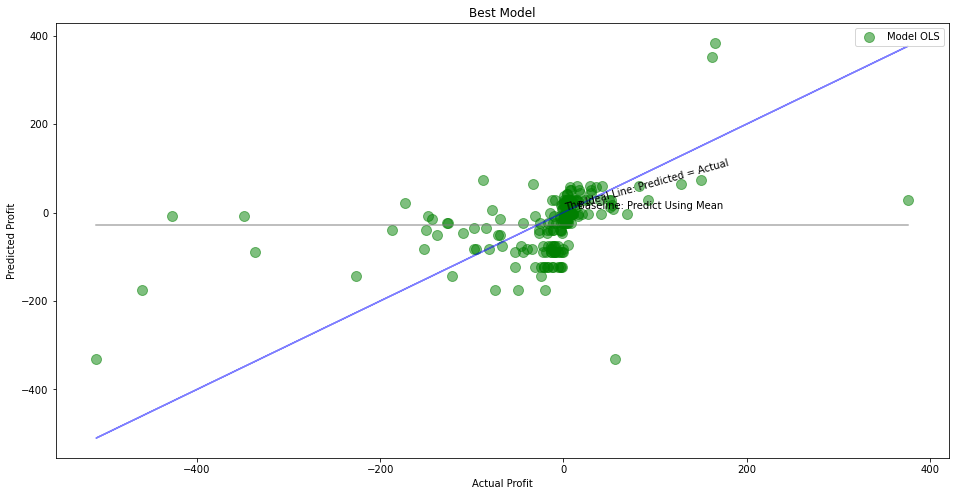

In [169]:

y_test_sample = y_test.sample(n=197)
y_train_sample = y_train.sample(n=197)


plt.figure(figsize=(16,8))
plt.plot(y_test_sample.Profit, y_train_sample.profit_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_test_sample.Profit, y_test_sample.Profit, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_test_sample.Profit, y_test_sample.profit_pred_lm, 
            alpha=.5, color="green", s=100, label="Model OLS")
plt.legend()
plt.xlabel("Actual Profit")
plt.ylabel("Predicted Profit")
plt.title("Best Model")
plt.show()

# Summary

## Key Takeaways
### Top 3 drivers of Profit were Category, Sub-Category, and Segment

- Office Supplies sales are costing us profits in Texas
- The few cities that made profit, only did so because they sold a limited amount of items.
- Overall Texas is losing money with Office Supplies consisting of 61% of sales.
- There is no difference between office supplies profit and Texas Mean Profit
---
- Tech sales cause profits to rise in Texas (Especially Copier sales)
- For tech sales in Texas, Machine sales lose profit and Copier sales make profit
- Home Office Segment makes the most profit compared to Consumer and Corporate Segments. 


## Recommendations:
#### We need to raise prices on Office Supplies in Texas to see a rise in Profit.

## If given more time...
- Investigate other states that are successful, and try to predict what implementing those practices in Texas would produce in Profit. 